# Detection d'object en Tensorflow

## Importation des packages

In [7]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
import os
from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout
print(f'La version Tensorflow est : {tf.__version__}')

La version Tensorflow est : 2.8.0


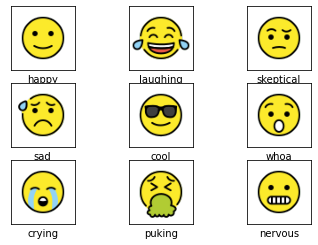

In [8]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i+1)
    plt.imshow(plt.imread(os.path.join('emojis', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

## Task 3: Create Examples

In [9]:
for class_id, values in emojis.items():
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    emojis[class_id]['image'] = new_file

In [11]:
emojis[0]

{'name': 'happy',
 'file': '1F642.png',
 'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x21524CCC520>}

In [18]:
def create_example():
    class_id = np.random.randint(0, 9)
    image = np.ones((144, 144, 3)) * 255
    
    row = np.random.randint(0, 72)
    col = np.random.randint(0, 72)
    image[row: row + 72, col: col + 72, :] = np.array(emojis[class_id]['image'])
    
    return image.astype('uint8'), class_id, (row + 10)/144, (col + 10)/144

In [28]:
image, class_id, row, col = create_example()

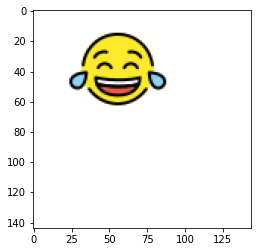

In [29]:
plt.imshow(image)